<a href="https://colab.research.google.com/github/samueleallen/Valorant-Match-Predictor-w-Scraper-/blob/main/ValorantMatchPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Cleaning/Prepping data for Machine Learning
Task List:
 * Aggregate player data to one row for each team  
 * Convert column types appropriately (e.g., object type to float for R2.0 feature)
 * Investigate missing data

In [ ]:
matches_df = pd.read_csv("/content/drive/My Drive/Colab CSV Files/overall_game_stats.csv")
matches_df.head()

,Player,R2.0,ACS,K,D,A,+/- K/D,KAST,ADR,HS%,FK,FD,+/- FK/FD,date,Team,vs Team,result,final_score
0,jawgemo,1.18,243.0,103,89,44,14,78%,160.0,28%,12.0,20.0,-8.0,3/2/2025,G2 Esports,T1,Loss,'2 : 3'
1,trent,1.11,224.0,92,79,40,13,75%,145.0,29%,14.0,9.0,5.0,3/2/2025,G2 Esports,T1,Loss,'2 : 3'
2,valyn,1.02,210.0,94,82,51,12,77%,138.0,25%,10.0,10.0,0.0,3/2/2025,G2 Esports,T1,Loss,'2 : 3'
3,leaf,0.81,190.0,79,86,31,-7,75%,119.0,21%,13.0,15.0,-2.0,3/2/2025,G2 Esports,T1,Loss,'2 : 3'
4,JonahP,0.92,162.0,74,87,42,-13,75%,105.0,28%,7.0,11.0,-4.0,3/2/2025,G2 Esports,T1,Loss,'2 : 3'


In [ ]:
# Define which columns should be aggregated using the mean
numeric_columns = ['R2.0', 'ACS', 'K', 'D', 'A', '+/- K/D', 'KAST', 'ADR', 'HS%', 'FK', 'FD', '+/- FK/FD']

# Convert date column from object to datetime
matches_df["date"] = pd.to_datetime(matches_df["date"])

# Convert percentage columns to numeric values (remove "%" and convert to float)
matches_df["KAST"] = matches_df["KAST"].str.rstrip('%').astype(float)
matches_df["HS%"] = matches_df["HS%"].str.rstrip('%').astype(float)

# Group each team match into one row
matches_df = matches_df.groupby(['date', 'Team', 'vs Team', 'result', 'final_score']).agg({col: 'mean' for col in numeric_columns}).reset_index()
matches_df.sort_values(by='date')
# Save to CSV file
# matches_df.to_csv('aggregated_matches.csv', index=False)
matches_df.head()


,date,Team,vs Team,result,final_score,R2.0,ACS,K,D,A,+/- K/D,KAST,ADR,HS%,FK,FD,+/- FK/FD
0,2023-02-13,DetonatioN FocusMe,Giants Gaming,Loss,'0 : 2',0.768333,166.5,17.333333,24.833333,6.833333,-7.5,60.0,107.333333,33.0,2.5,3.666667,-1.166667
1,2023-02-13,Giants Gaming,DetonatioN FocusMe,Win,'2 : 0',1.248000,218.0,29.800000,20.800000,11.000000,9.0,83.6,148.800000,30.4,4.4,3.000000,1.400000
2,2023-02-13,KOI,NRG Esports,Loss,'0 : 2',1.034000,170.6,27.000000,30.400000,12.600000,-3.4,68.0,113.000000,25.6,3.2,6.000000,-2.800000
3,2023-02-13,NRG Esports,KOI,Win,'2 : 0',1.198000,196.4,30.400000,27.000000,13.800000,3.4,77.2,126.800000,24.0,6.0,3.200000,2.800000
4,2023-02-14,BBL Esports,DRX,Loss,'1 : 2',0.876000,175.8,37.600000,45.800000,15.200000,-8.2,67.2,117.000000,28.4,5.2,6.800000,-1.600000


In [ ]:
matches_df.shape

(1536, 17)

In [ ]:
matches_df.dtypes

,0
date,datetime64[ns]
Team,object
vs Team,object
result,object
final_score,object
R2.0,float64
ACS,float64
K,float64
D,float64
A,float64


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Handle missing values
matches_df.fillna(0, inplace=True)

# Convert percentage columns like 'HS%' and 'KAST' to numeric
matches_df['HS%'] = pd.to_numeric(matches_df['HS%'], errors='coerce')  # Convert to numeric, handle errors by coercing to NaN
matches_df['KAST'] = pd.to_numeric(matches_df['KAST'], errors='coerce')

# Encode categorical columns like 'Player', 'Team', 'vs Team'
label_encoder = LabelEncoder()

# Convert 'final_score' to two separate columns for individual scores
matches_df[['final_score_winner', 'final_score_loser']] = matches_df['final_score'].str.split(':', expand=True)

# Convert the split columns to numeric
matches_df['final_score_winner'] = pd.to_numeric(matches_df['final_score_winner'], errors='coerce')
matches_df['final_score_loser'] = pd.to_numeric(matches_df['final_score_loser'], errors='coerce')

# Drop 'final_score' column as it is now split into 'final_score_winner' and 'final_score_loser'
matches_df.drop(columns=['final_score'], inplace=True)

# Convert 'result' to integers (0 for Loss, 1 for Win)
matches_df['result'] = matches_df['result'].replace({'Loss': 0, 'Win': 1})

# Check the result
matches_df.dtypes

<ipython-input-372-ee8f5cfda874>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matches_df['result'] = matches_df['result'].replace({'Loss': 0, 'Win': 1})


,0
date,datetime64[ns]
Team,object
vs Team,object
result,int64
R2.0,float64
ACS,float64
K,float64
D,float64
A,float64
+/- K/D,float64


## Step 2: Creating Initial Machine Learning Model

### 1. Creating Predictors for Machine Learning
 * Select relevant pre-match features
 * Calculate past performance stats (e.g., rolling averages)
 * Ensure no data leakage from test set

### 2. Creating Initial Machine Learning model
 * Split data into training and test sets
 * Initialize machine learning model
 * Train the model using `train` data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# maybe experiment with these values
rf = RandomForestClassifier(n_estimators=50, min_samples_split = 10, random_state = 1)

In [ ]:
# Filter the dataset based on date
train = matches_df[matches_df["date"] < '2025-02-19']
test = matches_df[matches_df["date"] >= '2025-02-19']

# Convert 'date' column to numeric (days since the first date)
train['date'] = (train['date'] - train['date'].min()).dt.days
test['date'] = (test['date'] - test['date'].min()).dt.days


<ipython-input-374-1b7af69e2b46>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = (train['date'] - train['date'].min()).dt.days
<ipython-input-374-1b7af69e2b46>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = (test['date'] - test['date'].min()).dt.days


In [ ]:
predictors = ['K', 'D', 'A', '+/- K/D', 'ADR', 'HS%', 'FK', 'FD', 'KAST']
# removed ['Team', 'vs Team'] for

In [ ]:
print(test[predictors].dtypes)


K          float64
D          float64
A          float64
+/- K/D    float64
ADR        float64
HS%        float64
FK         float64
FD         float64
KAST       float64
dtype: object


In [ ]:
rf.fit(train[predictors], train["result"])
temp = rf.fit(train[predictors], train["result"])

In [ ]:
# Now fit the model and predict
rf.fit(train[predictors], train["result"])
preds = rf.predict(test[predictors])

## Accuracy Rating
Important notes about the accuracy rating and precision score below:
 * The test set includes data from the match played when making a prediction.
 * This has led the model to having access to all the match data except for the winner/loser it is trying to predict.

All in all, this model can be used to tell us strategies and the importance of certain features in determining a win. However, by no means does this model reflect any sports betting model where all it is given is historical data from past matches.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc = accuracy_score(test["result"], preds)

In [ ]:
acc

1.0

In [ ]:
combined = pd.DataFrame(dict(actual=test["result"], predicted=preds))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,16,0
1,0,16


In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(test["result"], preds)

1.0

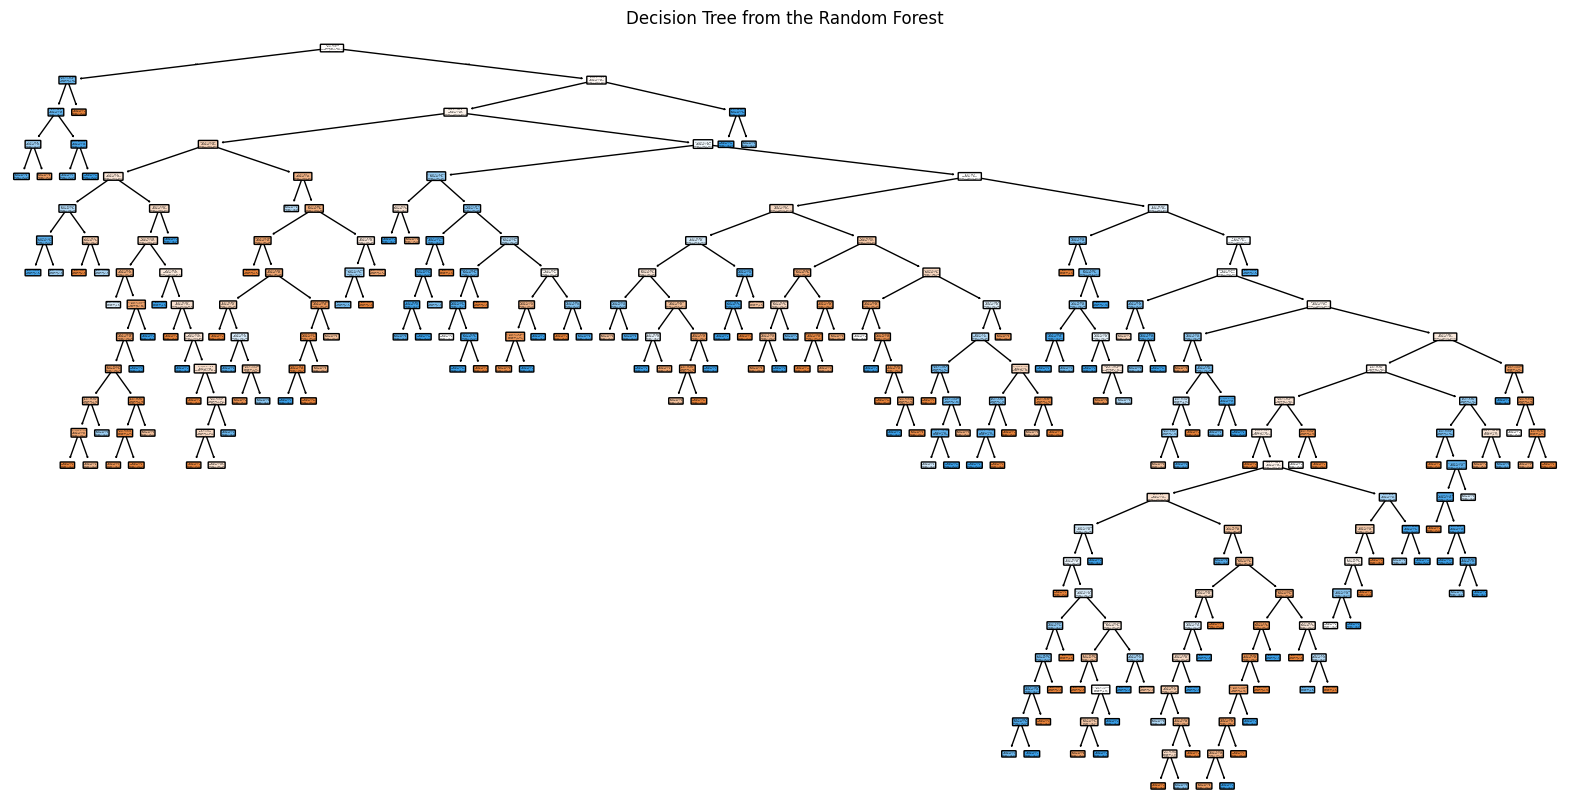

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# Plot the tree using the plot_tree function from sklearn
tree = temp.estimators_[0]
plt.figure(figsize=(20,10))  # Set figure size to make the tree more readable
plot_tree(tree,
          feature_names=predictors,  # Use the feature names from the dataset
          class_names=['Loss', 'Win'],  # Class names for the target variable
          filled=True,              # Fill nodes with colors for better visualization
          rounded=True)             # Rounded edges for nodes
plt.title("Decision Tree from the Random Forest")
plt.show()
plt.savefig('tree.png')

## Betting Model
For this model, the test set will include historical performances of teams rather than the actual match data from the match the model is trying to predict.  
  
A couple of ways to do this:   
 * Rolling averages
 * Cumulative average

First we will look at implementing rolling averages in our test set

In [ ]:
grouped_matches = matches_df.groupby("Team")

In [ ]:
# Each team has a unique integer ID rather than a string for team name
group = grouped_matches.get_group("G2 Esports").sort_values("date")

In [ ]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")  # Sort group data by date
    numeric_cols = group[cols].select_dtypes(include=['number'])  # Select numeric columns, ignore dates
    rolling_stats = numeric_cols.rolling(3, closed='left').mean()  # Compute rolling average
    # Assign the rolling stats back to the group, ensuring the new columns are added correctly
    for i, col in enumerate(rolling_stats.columns):
        group[new_cols[i]] = rolling_stats[col]
    # group = group.dropna(subset=new_cols)  # Drop rows with NaN in the new columns
    group = group.drop(['final_score_loser', 'final_score_winner'], axis = 1)
    return group

In [ ]:
cols = ['K', 'D', 'A', '+/- K/D', 'ADR', 'HS%', 'FK', 'FD', 'KAST']
new_cols = [f"{c}_rolling" for c in cols]

In [ ]:
new_cols

['K_rolling',
 'D_rolling',
 'A_rolling',
 '+/- K/D_rolling',
 'ADR_rolling',
 'HS%_rolling',
 'FK_rolling',
 'FD_rolling',
 'KAST_rolling']

In [ ]:
rolling_averages(group, cols, new_cols)

,date,Team,vs Team,result,R2.0,ACS,K,D,A,+/- K/D,...,+/- FK/FD,K_rolling,D_rolling,A_rolling,+/- K/D_rolling,ADR_rolling,HS%_rolling,FK_rolling,FD_rolling,KAST_rolling
542,2024-02-18,G2 Esports,KRÜ Esports,1,1.104,203.0,47.4,45.8,19.2,1.6,...,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
611,2024-02-24,G2 Esports,Evil Geniuses,0,0.908,196.2,35.8,37.0,13.8,-1.2,...,-1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,2024-02-25,G2 Esports,KRÜ Esports,1,1.290,211.8,31.0,26.0,15.8,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,2024-02-26,G2 Esports,MIBR,0,0.892,190.0,48.2,52.6,15.8,-4.4,...,0.2,38.066667,36.266667,16.266667,1.800000,136.066667,28.200000,4.800000,6.000000,74.333333
640,2024-02-26,G2 Esports,Sentinels,1,0.848,195.0,45.0,44.0,17.6,1.0,...,1.0,38.333333,38.533333,15.133333,-0.200000,134.733333,29.866667,5.333333,5.800000,73.666667
744,2024-04-07,G2 Esports,Evil Geniuses,1,1.426,227.6,30.8,22.0,15.0,8.8,...,2.2,41.400000,40.866667,16.400000,0.533333,132.933333,28.533333,6.200000,5.800000,73.533333
782,2024-04-13,G2 Esports,100 Thieves,0,0.882,187.2,27.0,30.6,15.0,-3.6,...,-0.6,41.333333,39.533333,16.133333,1.800000,133.400000,28.200000,6.400000,5.266667,73.466667
855,2024-04-22,G2 Esports,FURIA,1,1.354,226.8,27.8,15.0,9.8,12.8,...,3.2,34.266667,32.200000,15.866667,2.066667,131.333333,25.533333,5.266667,4.400000,74.000000
868,2024-04-24,G2 Esports,LEVIATÁN,0,0.812,181.8,38.6,45.8,10.8,-7.2,...,-2.4,28.533333,22.533333,13.266667,6.000000,136.266667,24.533333,4.533333,2.933333,79.533333
892,2024-04-27,G2 Esports,MIBR,1,1.180,225.2,30.8,24.2,11.2,6.6,...,-0.4,31.133333,30.466667,11.866667,0.666667,128.200000,26.133333,4.600000,4.533333,74.933333


In [ ]:
matches_rolling = matches_df.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))

<ipython-input-391-9aca10a36645>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches_df.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))


In [ ]:
matches_rolling

date           Team            vs Team  result  \
Team                                                                      
100 Thieves   34   2023-02-23    100 Thieves      EDward Gaming       1   
              48   2023-02-26    100 Thieves        FUT Esports       1   
              52   2023-02-27    100 Thieves             FNATIC       0   
              92   2023-04-01    100 Thieves          Sentinels       0   
              138  2023-04-10    100 Thieves      Evil Geniuses       1   
...                       ...            ...                ...     ...   
ZETA DIVISION 1163 2024-06-29  ZETA DIVISION     Rex Regum Qeon       0   
              1227 2024-07-06  ZETA DIVISION              TALON       1   
              1239 2024-07-07  ZETA DIVISION          Paper Rex       0   
              1375 2025-01-18  ZETA DIVISION  Nongshim RedForce       0   
              1439 2025-01-26  ZETA DIVISION          Paper Rex       0   

                     R2.0    ACS     K     D     A  +/- K/D  ...  +/- FK/FD  \
Team                                                         ...              
100 Thieves   34    1.142  203.0  50.6  50.4  22.2      0.2  ...       -3.0   
              48    1.146  216.2  50.4  47.0  28.4      3.4  ...        1.4   
              52    0.574  167.6  21.6  31.8   7.4    -10.2  ...       -2.6   
              92    0.848  185.4  48.8  56.0  23.6     -7.2  ...        3.2   
              138   1.220  224.0  32.2  23.6  14.4      8.6  ...        0.4   
...                   ...    ...   ...   ...   ...      ...  ...        ...   
ZETA DIVISION 1163  1.088  182.4  27.4  31.0  13.2     -3.6  ...       -0.4   
              1227  0.972  208.2  44.4  38.8  20.8      5.6  ...        1.8   
              1239  1.056  185.8  38.6  48.0  14.8     -9.4  ...       -2.8   
              1375  0.848  189.8  28.6  33.2  11.0     -4.6  ...       -0.8   
              1439  0.738  169.2  22.4  33.0   7.8    -10.6  ...       -1.8   

                    K_rolling  D_rolling  A_rolling  +/- K/D_rolling  \
Team                                                                   
100 Thieves   34          NaN        NaN        NaN              NaN   
              48          NaN        NaN        NaN              NaN   
              52          NaN        NaN        NaN              NaN   
              92    40.866667  43.066667  19.333333        -2.200000   
              138   40.266667  44.933333  19.800000        -4.666667   
...                       ...        ...        ...              ...   
ZETA DIVISION 1163  41.266667  46.733333  21.133333        -5.466667   
              1227  34.800000  40.266667  17.800000        -5.466667   
              1239  38.800000  38.933333  18.666667        -0.133333   
              1375  36.800000  39.266667  16.266667        -2.466667   
              1439  37.200000  40.000000  15.533333        -2.800000   

                    ADR_rolling  HS%_rolling  FK_rolling  FD_rolling  \
Team                                                                   
100 Thieves   34            NaN          NaN         NaN         NaN   
              48            NaN          NaN         NaN         NaN   
              52            NaN          NaN         NaN         NaN   
              92     132.000000    26.133333    5.133333    6.533333   
              138    126.466667    24.866667    6.333333    5.666667   
...                         ...          ...         ...         ...   
ZETA DIVISION 1163   126.266667    30.600000    5.466667    7.066667   
              1227   123.266667    31.600000    5.133333    5.733333   
              1239   129.866667    31.933333    5.600000    5.733333   
              1375   127.200000    31.600000    5.266667    5.733333   
              1439   127.400000    32.200000    5.200000    5.800000   

                    KAST_rolling  
Team                              
100 Thieves   34             NaN  
              48             NaN  
       

In [ ]:
matches_rolling = matches_rolling.droplevel('Team')

In [ ]:
matches_rolling

,date,Team,vs Team,result,R2.0,ACS,K,D,A,+/- K/D,...,+/- FK/FD,K_rolling,D_rolling,A_rolling,+/- K/D_rolling,ADR_rolling,HS%_rolling,FK_rolling,FD_rolling,KAST_rolling
34,2023-02-23,100 Thieves,EDward Gaming,1,1.142,203.0,50.6,50.4,22.2,0.2,...,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,2023-02-26,100 Thieves,FUT Esports,1,1.146,216.2,50.4,47.0,28.4,3.4,...,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2023-02-27,100 Thieves,FNATIC,0,0.574,167.6,21.6,31.8,7.4,-10.2,...,-2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,2023-04-01,100 Thieves,Sentinels,0,0.848,185.4,48.8,56.0,23.6,-7.2,...,3.2,40.866667,43.066667,19.333333,-2.200000,132.000000,26.133333,5.133333,6.533333,70.533333
138,2023-04-10,100 Thieves,Evil Geniuses,1,1.220,224.0,32.2,23.6,14.4,8.6,...,0.4,40.266667,44.933333,19.800000,-4.666667,126.466667,24.866667,6.333333,5.666667,70.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,2024-06-29,ZETA DIVISION,Rex Regum Qeon,0,1.088,182.4,27.4,31.0,13.2,-3.6,...,-0.4,41.266667,46.733333,21.133333,-5.466667,126.266667,30.600000,5.466667,7.066667,69.933333
1227,2024-07-06,ZETA DIVISION,TALON,1,0.972,208.2,44.4,38.8,20.8,5.6,...,1.8,34.800000,40.266667,17.800000,-5.466667,123.266667,31.600000,5.133333,5.733333,70.533333
1239,2024-07-07,ZETA DIVISION,Paper Rex,0,1.056,185.8,38.6,48.0,14.8,-9.4,...,-2.8,38.800000,38.933333,18.666667,-0.133333,129.866667,31.933333,5.600000,5.733333,72.266667
1375,2025-01-18,ZETA DIVISION,Nongshim RedForce,0,0.848,189.8,28.6,33.2,11.0,-4.6,...,-0.8,36.800000,39.266667,16.266667,-2.466667,127.200000,31.600000,5.266667,5.733333,69.733333


In [ ]:
matches_rolling.index = range(matches_rolling.shape[0])

In [ ]:
def make_predictions(data, predictors):
  train = data[data["date"] < '2025-02-19']
  test = data[data["date"] >= '2025-02-19']
  rf.fit(train[predictors], train["result"])
  preds = rf.predict(test[predictors])
  combined = pd.DataFrame(dict(actual=test["result"], predicted=preds), index=test.index)
  precision = precision_score(test["result"], preds)
  return combined, precision

In [ ]:
print(matches_rolling.columns)

Index(['date', 'Team', 'vs Team', 'result', 'R2.0', 'ACS', 'K', 'D', 'A',
       '+/- K/D', 'KAST', 'ADR', 'HS%', 'FK', 'FD', '+/- FK/FD', 'K_rolling',
       'D_rolling', 'A_rolling', '+/- K/D_rolling', 'ADR_rolling',
       'HS%_rolling', 'FK_rolling', 'FD_rolling', 'KAST_rolling'],
      dtype='object')


In [ ]:
print(predictors + new_cols)

['K', 'D', 'A', '+/- K/D', 'ADR', 'HS%', 'FK', 'FD', 'KAST', 'K_rolling', 'D_rolling', 'A_rolling', '+/- K/D_rolling', 'ADR_rolling', 'HS%_rolling', 'FK_rolling', 'FD_rolling', 'KAST_rolling']


In [ ]:
new_rolling_predictors = [col for col in new_cols]
combined, precision = make_predictions(matches_rolling, new_rolling_predictors)

In [ ]:
precision

0.5909090909090909

In [ ]:
matches_rolling

,date,Team,vs Team,result,R2.0,ACS,K,D,A,+/- K/D,...,+/- FK/FD,K_rolling,D_rolling,A_rolling,+/- K/D_rolling,ADR_rolling,HS%_rolling,FK_rolling,FD_rolling,KAST_rolling
0,2023-02-23,100 Thieves,EDward Gaming,1,1.142,203.0,50.6,50.4,22.2,0.2,...,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-26,100 Thieves,FUT Esports,1,1.146,216.2,50.4,47.0,28.4,3.4,...,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-27,100 Thieves,FNATIC,0,0.574,167.6,21.6,31.8,7.4,-10.2,...,-2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-01,100 Thieves,Sentinels,0,0.848,185.4,48.8,56.0,23.6,-7.2,...,3.2,40.866667,43.066667,19.333333,-2.200000,132.000000,26.133333,5.133333,6.533333,70.533333
4,2023-04-10,100 Thieves,Evil Geniuses,1,1.220,224.0,32.2,23.6,14.4,8.6,...,0.4,40.266667,44.933333,19.800000,-4.666667,126.466667,24.866667,6.333333,5.666667,70.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2024-06-29,ZETA DIVISION,Rex Regum Qeon,0,1.088,182.4,27.4,31.0,13.2,-3.6,...,-0.4,41.266667,46.733333,21.133333,-5.466667,126.266667,30.600000,5.466667,7.066667,69.933333
1532,2024-07-06,ZETA DIVISION,TALON,1,0.972,208.2,44.4,38.8,20.8,5.6,...,1.8,34.800000,40.266667,17.800000,-5.466667,123.266667,31.600000,5.133333,5.733333,70.533333
1533,2024-07-07,ZETA DIVISION,Paper Rex,0,1.056,185.8,38.6,48.0,14.8,-9.4,...,-2.8,38.800000,38.933333,18.666667,-0.133333,129.866667,31.933333,5.600000,5.733333,72.266667
1534,2025-01-18,ZETA DIVISION,Nongshim RedForce,0,0.848,189.8,28.6,33.2,11.0,-4.6,...,-0.8,36.800000,39.266667,16.266667,-2.466667,127.200000,31.600000,5.266667,5.733333,69.733333


In [ ]:
combined = combined.merge(matches_rolling[["Team", "vs Team", "date"]], right_index=True, left_index=True)

In [ ]:
combined.head(10)

,actual,predicted,Team,vs Team,date
211,1,1,DRX,Sentinels,2025-02-20
212,0,0,DRX,Team Vitality,2025-02-22
213,0,0,DRX,T1,2025-02-24
309,1,1,EDward Gaming,Team Liquid,2025-02-20
310,1,1,EDward Gaming,G2 Esports,2025-02-22
311,1,1,EDward Gaming,T1,2025-02-27
312,0,1,EDward Gaming,G2 Esports,2025-02-28
313,0,1,EDward Gaming,T1,2025-03-01
545,1,1,G2 Esports,Trace Esports,2025-02-21
546,0,1,G2 Esports,EDward Gaming,2025-02-22


## Betting Accuracy
When the model is fed rolling averages of teams, it boasts an accuracy of 59.09%

Future Improvements:
 * Try XGBoost
 * Research other statistical methods
 * Find more features to implement (e.g., time of match, jetlag, team elo)